In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
X, y = mnist.data, mnist.target

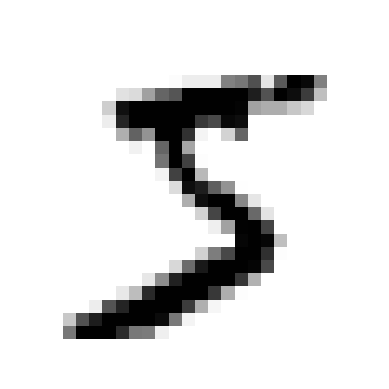

5


In [9]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()
print(y[0])

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
y_train_5 = (y_train == '5')  # 5는 True, 다른 숫자는 모두 False
y_test_5 = (y_test == '5')

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

이것으로 PCA 안 한 데이터에 대한 SGDClassifier는 훈련 완료. </br>
성능 검사해보자.

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # 데이터 안 섞었으면, shuffle=True 추가

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [8]:
# 더미 분류기
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [13]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [14]:
# 오차 행렬
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# kFolds 교차 검증을 수행하나, 평가 점수 반환 않고 테스트 폴드에서 얻은 예측 반환

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
y_train_perfect_predictions = y_train_5

In [27]:
# F_1 점수 호출 (정밀도 및 재현율)
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [26]:
%time sgd_clf.fit(X_train, y_train)

CPU times: user 3min 51s, sys: 426 ms, total: 3min 51s
Wall time: 3min 54s


SGDClassifier(random_state=42)

---
PCA 분산 95%로 맞춘 데이터 + SGDClassifier

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [30]:
pca.explained_variance_ratio_

array([9.70466436e-02, 7.09592406e-02, 6.16908876e-02, 5.38941949e-02,
       4.86879702e-02, 4.31223132e-02, 3.27192995e-02, 2.88389545e-02,
       2.76202940e-02, 2.35700055e-02, 2.10918962e-02, 2.02299108e-02,
       1.71581820e-02, 1.69211143e-02, 1.57864128e-02, 1.48295261e-02,
       1.32456095e-02, 1.27689737e-02, 1.18726294e-02, 1.15268370e-02,
       1.06616621e-02, 1.00671337e-02, 9.53573327e-03, 9.12543746e-03,
       8.83404692e-03, 8.39319141e-03, 8.12578809e-03, 7.86366084e-03,
       7.44733102e-03, 6.90859128e-03, 6.58093773e-03, 6.48147870e-03,
       6.02615030e-03, 5.86582188e-03, 5.70021474e-03, 5.43627771e-03,
       5.05786416e-03, 4.87858604e-03, 4.81429342e-03, 4.72266326e-03,
       4.56746921e-03, 4.44836012e-03, 4.18501329e-03, 3.98215339e-03,
       3.84974607e-03, 3.75103387e-03, 3.62008852e-03, 3.51591277e-03,
       3.40058205e-03, 3.21874467e-03, 3.19017051e-03, 3.12804939e-03,
       2.95982668e-03, 2.88954600e-03, 2.84130398e-03, 2.71435811e-03,
      

In [32]:
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d = 154

In [45]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_reduced_test = pca.fit_transform(X_test)

In [38]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3))

clf.fit(X_reduced, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [39]:
print(clf.score(X_reduced, y_train))
%time clf.fit(X_reduced, y_train)

0.9082
CPU times: user 22.8 s, sys: 27.7 ms, total: 22.8 s
Wall time: 22.8 s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [46]:
print(clf.score(X_reduced_test, y_test))

0.5151
